In [34]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt


# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [35]:
conn = sqlite3.connect("../db.sqlite3")
cursor = conn.cursor()

query = '''
SELECT oi.id AS order_item_id, oi.quantity, oi.order_id, oi.product_id,
       o.datetime AS order_datetime, p.name AS product_name, p.price
FROM restaurant_orderitem oi
JOIN restaurant_order o ON oi.order_id = o.id
JOIN restaurant_product p ON oi.product_id = p.id;
'''
cursor.execute(query)
data = cursor.fetchall()

with open("restaurant_data.csv", "w") as f:
    f.write("order_item_id,quantity,order_id,product_id,order_datetime,product_name,price\n")
    for row in data:
        f.write(",".join(map(str, row)) + "\n")

conn.close()

df = pd.read_csv("restaurant_data.csv")

print("Number of rows:", len(df))


Number of rows: 74818


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

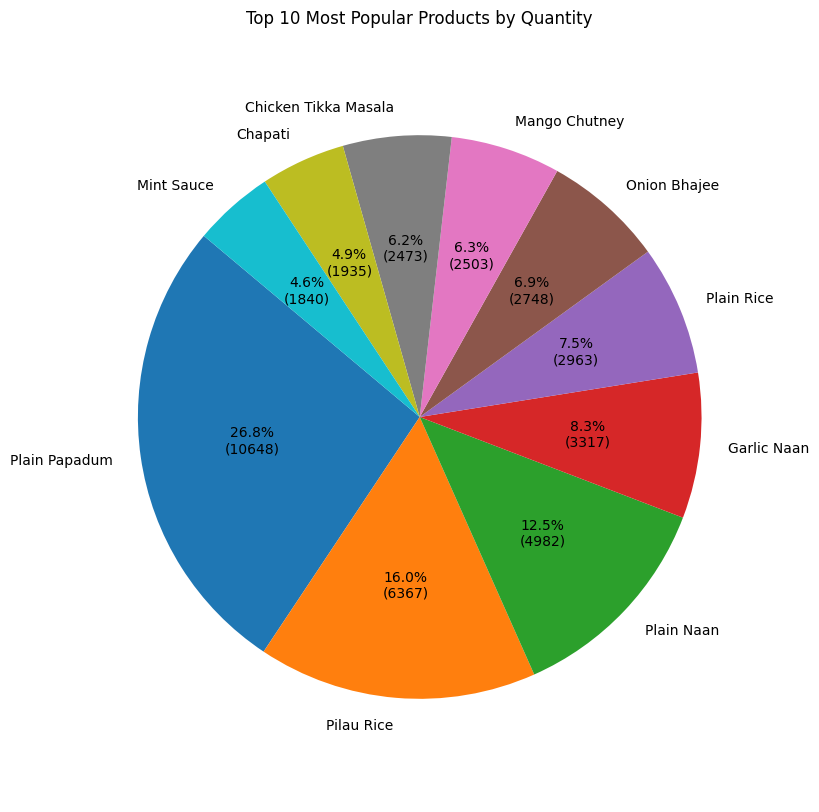

In [36]:
product_popularity = df.groupby("product_name")["quantity"].sum().sort_values(ascending=False)
top_10_popular_products = product_popularity.head(10)

def custom_autopct(pct):
    total = sum(top_10_popular_products)
    quantity = int(pct/100.*total)
    return "{:.1f}%\n({:d})".format(pct, quantity)

plt.figure(figsize=(8, 10))
plt.pie(top_10_popular_products, labels=top_10_popular_products.index, autopct=custom_autopct, startangle=140)
plt.title("Top 10 Most Popular Products by Quantity")
plt.axis("equal")

plt.show()


# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

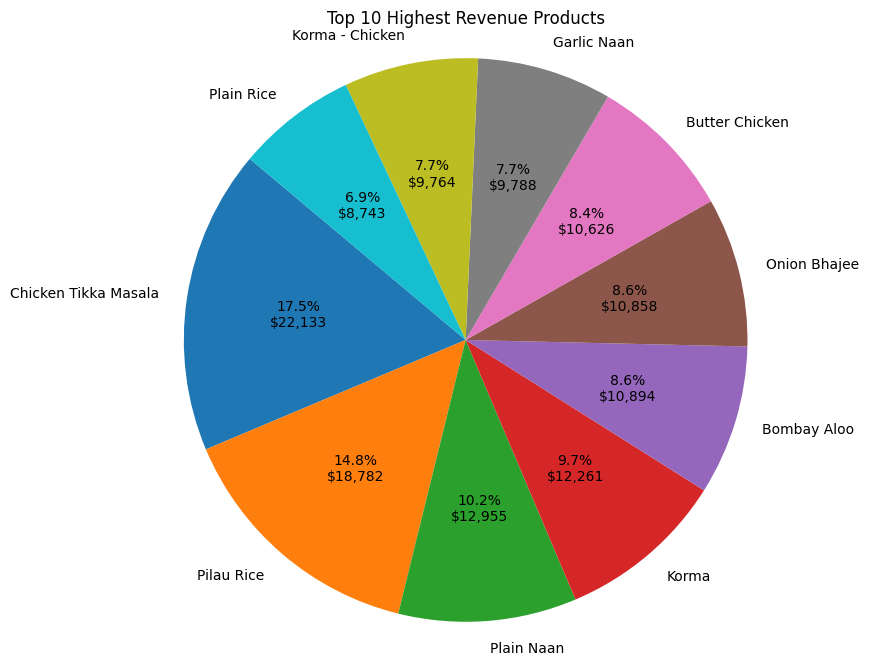

In [37]:
df["item_price"] = df["price"] * df["quantity"]

product_revenue = df.groupby("product_name")["item_price"].sum().sort_values(ascending=False)
top_10_high_revenue_products = product_revenue.head(10)

def custom_autopct(pct):
    total_revenue = sum(top_10_high_revenue_products)
    revenue = int(pct / 100. * total_revenue)
    return "{:.1f}%\n${:,}".format(pct, revenue)
    
plt.figure(figsize=(8, 8))
plt.pie(top_10_high_revenue_products, labels=top_10_high_revenue_products.index, autopct=custom_autopct, startangle=140)
plt.title("Top 10 Highest Revenue Products")
plt.axis("equal")

plt.show()


# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

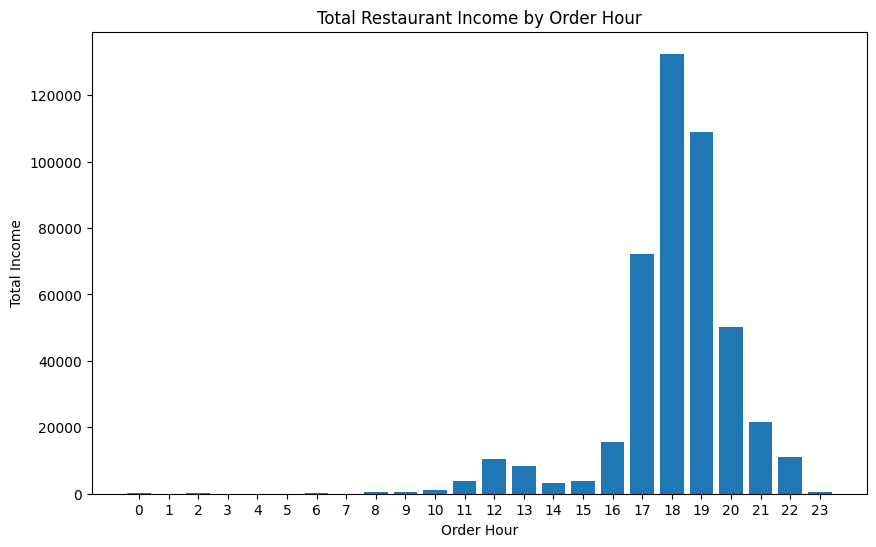

In [38]:
df["order_datetime"] = pd.to_datetime(df["order_datetime"])

df["order_hour"] = df["order_datetime"].dt.hour

hourly_income = df.groupby("order_hour")["quantity"].sum() * df.groupby("order_hour")["price"].mean()

plt.figure(figsize=(10, 6))
plt.bar(hour_income.index, hour_income.values)
plt.xlabel("Order Hour")
plt.ylabel("Total Income")
plt.title("Total Restaurant Income by Order Hour")
plt.xticks(range(24))
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

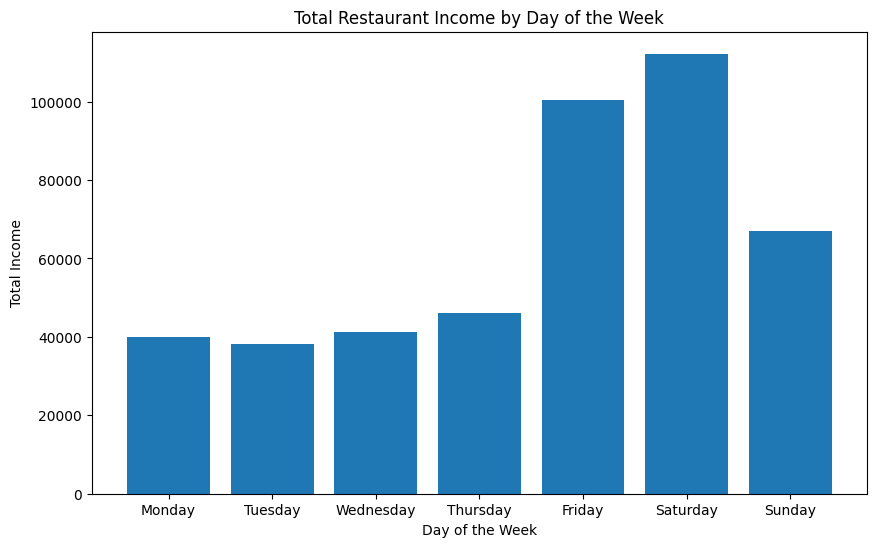

In [39]:
df["order_day_of_week"] = df["order_datetime"].dt.dayofweek
day_of_week_income = df.groupby("order_day_of_week")["item_price"].sum().sort_index()
day_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(10, 6))
plt.bar(day_of_week_income.index, day_of_week_income.values)
plt.xlabel("Day of the Week")
plt.ylabel("Total Income")
plt.title("Total Restaurant Income by Day of the Week")
plt.xticks(range(7), day_labels)
plt.show()